In [16]:
import ee

ee.Authenticate()
ee.Initialize()



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=JXXax2-KLh_T6E-RO2p8aMY3hmV3gqjrxEj6JbsuOcg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWihac113mYyXGjO0h-PzoGRJafiBUiavJuRHkuYFLd9I2KL_r_5Mjc

Successfully saved authorization token.


In [17]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [18]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [19]:
# Define the urban location of interest as a point near Milan, Italy.
lon = 9.189982
lat = 45.464203
poi = ee.Geometry.Point(lon, lat)


In [20]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 133 m
Average daytime LST at urban point: 26.13 °C
Land cover value at urban point is: 13


In [21]:
# Get the data for the pixel intersecting the point in urban area.
lst_poi = lst.getRegion(poi, scale).getInfo()

# Preview the result.
lst_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  9.194256932963302,
  45.468228105709585,
  1483228800000,
  13954,
  145],
 ['2017_01_02', 9.194256932963302, 45.468228105709585, 1483315200000, None, 2],
 ['2017_01_03', 9.194256932963302, 45.468228105709585, 1483401600000, None, 2],
 ['2017_01_04', 9.194256932963302, 45.468228105709585, 1483488000000, None, 2]]

In [22]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [23]:
lst_df = ee_array_to_df(lst_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df['LST_Day_1km'] = lst_df['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,5.93
5,1483660800000,2017-01-06,4.67
6,1483747200000,2017-01-07,3.57
8,1483920000000,2017-01-09,3.97
14,1484438400000,2017-01-15,7.01


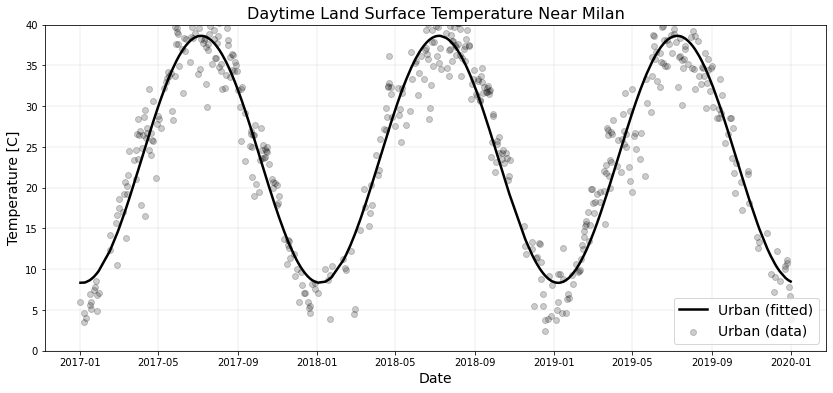

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df['LST_Day_1km'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])


# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df['datetime'], lst_df['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')


# Add fitting curves.
ax.plot(lst_df['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Milan', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [25]:
# Define a region of interest with a buffer zone of 1000 km around Milan.
roi = poi.buffer(1e6)

In [26]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [27]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/31e5ada2c6aba96b638037378b40aa51-f9aace458c7f8303e83205843c456b6d:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [28]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in Italy.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [36]:
# Create a buffer zone of 500 km around Lyon.
milan = poi.buffer(500000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': milan, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)
print(url)

In [37]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
italy = countries.filter(ee.Filter.eq('ADM0_NAME', 'Italy'))

# Clip the image by France.
elv_fr = elv_img.clip(italy)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Italy.
Image(url=url)
print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e03348287ba9c95863673bd1c909b84f-2484b4c3de026d25634a4c6002469c5c:getPixels


In [32]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_milan_italy',
                                     scale=30,
                                     region=milan,
                                     fileNamePrefix='my_export_milan',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()
task.status()

{'creation_timestamp_ms': 1647032427029,
 'description': 'elevation_near_milan_italy',
 'id': 'EVFMLI7363GOZVJVCWZLCYRN',
 'name': 'projects/earthengine-legacy/operations/EVFMLI7363GOZVJVCWZLCYRN',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1647032427029}